In [26]:
import os
import time
import datetime
import xarray as xr
import rioxarray as rxr
import numpy as np
import cftime as cf
import cfunits
from urllib.request import urlretrieve

In [3]:
# vars
sdate = datetime.datetime(2020, 1, 1)
edate = datetime.datetime(2050, 1, 1)
proj = 'EPSG:4326'
github_path = 'https://github.com/rubisco-sfa/ILAMB-Data/blob/msteckler/GFW/convert.py'

# data sources
remote_data = 'https://www.arcgis.com/sharing/rest/content/items/f950ea7878e143258a495daddea90cc0/data'
local_data = 'sequestration_rate_mean_aboveground_full_extent_Mg_C_ha_yr.tif'
remote_u_data = 'https://www.arcgis.com/sharing/rest/content/items/d28470313b8e443aa90d5cbcd0f74163/data'
local_u_data = 'sequestration_error_ratio_layer_in_full_extent.tif'

In [4]:
# Open the uncertainty raster
def open_raster(local_data, remote_data):
    if not os.path.isfile(local_data):
        urlretrieve(remote_data, local_data)
    download_stamp = time.strftime('%Y-%m-%d', time.localtime(os.path.getmtime(local_data)))
    data = rxr.open_rasterio(local_data, band_as_variable=True)
    
    # ensure data is not projected and is wgs84
    epsg_code = int(data.rio.crs.to_epsg())
    if epsg_code != 4326:
        data = data.rio.reproject(crs=proj)

    return data, download_stamp

In [5]:
data, download_stamp = open_raster(local_data, remote_data)
errd, _ = open_raster(local_u_data, remote_u_data)

In [6]:
# resample to 0.5 degrees
def coarsen(target_res, data):
    resampled_data = data.coarsen(x=(int(target_res / abs(data.rio.resolution()[0]))),
                                  y=(int(target_res / abs(data.rio.resolution()[1])))).mean()
    return resampled_data

In [7]:
data = coarsen(0.5, data)
errd = coarsen(0.5, errd)

In [8]:
# rename dims
ds = data.rename({'x': 'lon', 'y': 'lat', 'band_1':'fVeg'})
er = errd.rename({'x': 'lon', 'y': 'lat', 'band_1':'error_ratio'})
# convert error ratio to standard error
er['standard_error'] = er['error_ratio'] * ds['fVeg']

In [9]:
# numpy array of time bounds
tb_arr = np.asarray([
    [cf.DatetimeNoLeap(sdate.year, sdate.month, sdate.day)],
    [cf.DatetimeNoLeap(edate.year, edate.month, edate.day)]
]).T

In [10]:
# xarray data array of time bounds
tb_da = xr.DataArray(tb_arr, dims=('time', 'nv'))

In [11]:
# add time dimension and time bounds attribute
ds = ds.expand_dims(time=tb_da.mean(dim='nv'))
ds['time_bounds'] = tb_da
er = er.expand_dims(time=tb_da.mean(dim='nv'))
er['time_bounds'] = tb_da

In [12]:
# add standard error variable
ds = ds.assign(standard_error=er['standard_error'])

In [13]:
# SEE: https://cfconventions.org/Data/cf-documents/requirements-recommendations/conformance-1.8.html
# edit time attributes
t_attrs = {
    'axis':'T',
    'long_name':'time',
    'bounds':'time_bounds'}

In [14]:
# edit lat/lon attributes
y_attrs = {
    'axis':'Y',
    'long_name':'latitude',
    'units':'degrees_north'}
x_attrs = {
    'axis':'X',
    'long_name':'longitude',
    'units':'degrees_east'}

In [15]:
# edit variable attributes
v_attrs = {
    'long_name': 'mean aboveground biomass carbon accumulation rate',
    'units': 'Mg ha-1 yr-1',
    'ancillary_variables': 'fVeg standard_error'}
e_attrs = {
    'long_name': 'standard error in mean aboveground biomass carbon accumulation rates',
    'units': 1}

In [16]:
ds['time'].attrs = t_attrs
ds['time'].encoding['units'] = 'days since 2020-01-01 00:00:00' #to_netcdf will fail without this
ds['time'].encoding['calendar'] = 'noleap'
ds['lat'].attrs = y_attrs
ds['lon'].attrs = x_attrs
ds['fVeg'].attrs = v_attrs
ds['standard_error'].attrs = e_attrs

In [17]:
# function to convert units
def convert_units(data_array, target_units):
    
    # create a cfunits.Units object for the target units
    original_units = data_array.attrs.get('units', None) 
    original_units_obj = cfunits.Units(original_units)
    target_units_obj = cfunits.Units(target_units)
    
    # convert
    new_array = cfunits.Units.conform(data_array, original_units_obj, target_units_obj)
    
    # create a new DataArray with converted values and update units
    new_data_array = xr.DataArray(
        new_array,
        dims=data_array.dims,
        coords=data_array.coords,
        attrs=data_array.attrs)
    
    new_data_array.attrs['units'] = target_units
    return new_data_array

# Convert air temperature from Kelvin to Celsius
ds['fVeg'] = convert_units(ds['fVeg'], 'kg m-2 s-1')

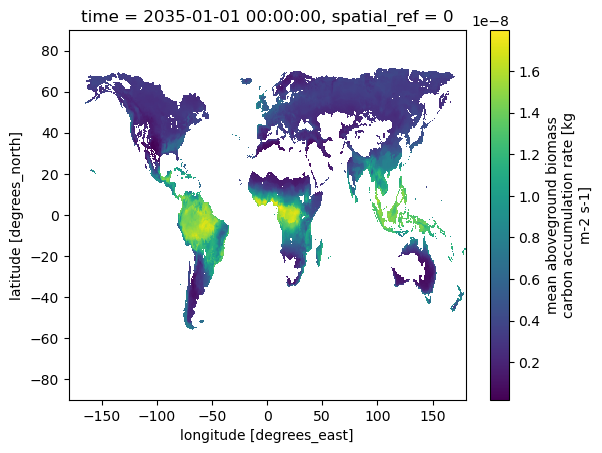

In [18]:
ds['fVeg'].plot()

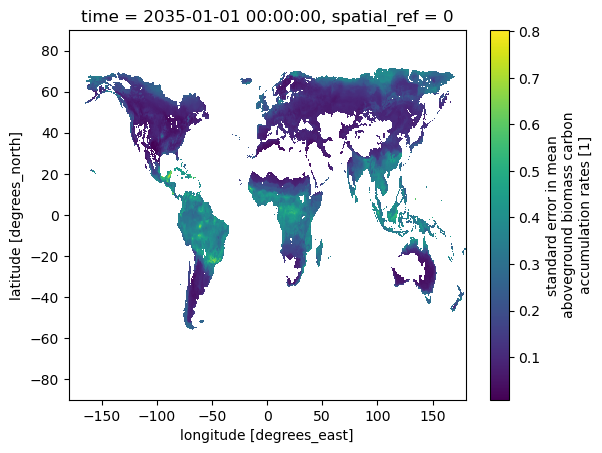

In [19]:
ds['standard_error'].plot()

In [20]:
# edit global attributes
generate_stamp = time.strftime('%Y-%m-%d', time.localtime(os.path.getmtime(local_data)))
ds.attrs = {
    'title':'Carbon accumulation potential from natural forest regrowth in forest and savanna biomes',
    'institution':'Global Forest Watch',
    'source':'Ensemble of 100 random forest models using ground measurements and 66 co-located environmental covariate layers',
    'history':f"""
{download_stamp}: downloaded source from {remote_data}
{generate_stamp}: resampled to 0.5 degree resolution
{generate_stamp}: converted units from Mg ha-1 yr-1 to CMIP standard kg m-2 s-1
{generate_stamp}: converted error ratio to standard error
{generate_stamp}: created CF-compliant metadata
{generate_stamp}: details on this process can be found at {github_path}""",
    'references': """
@article{Cook-Patton2020,
author  = {Cook-Patton, Susan and Leavitt, Sara and Gibbs, David and Harris, Nancy and Lister, Kristine and Anderson-Teixeira, Kristina and Briggs, Russell and Chazdon, Robin and Crowther, Thomas and Ellis, Peter and Griscom, Heather and Herrmann, Valentine and Holl, Karen and Houghton, Richard and Larrosa, Cecilia and Lomax, Guy and Lucas, Richard and Madsen, Palle and Malhi, Yadvinder and Paquette, Alain and Parker, John and Paul, Keryn and Routh, Devin and Roxburgh, Stephen and Saatchi, Sassan and van den Hoogen, Johan and Walker, Wayne and Wheeler, Charlotte and Wood, Stephen and Xu, Liang and Griscom, Bronson},
title   = {Mapping carbon accumulation potential from global natural forest regrowth},
journal = {Nature},
year    = {2020},
volume  = {585},
pages   = {545--550},
doi     = {10.1038/s41586-020-2686-x}}""",
    'comment':'',
    'Conventions':'CF-1.11'}

In [21]:
# tidy up
ds['lat'] = ds['lat'].astype('float32')
ds['lon'] = ds['lon'].astype('float32')
ds = ds.drop_vars('spatial_ref')
ds = ds.reindex(lat=list(reversed(ds.lat)))

In [22]:
ds.to_netcdf('cookpatton2020.nc', format='NETCDF4', engine='netcdf4')

### test output netcdf

In [27]:
test = xr.open_dataset('cookpatton2020.nc', engine='netcdf4')

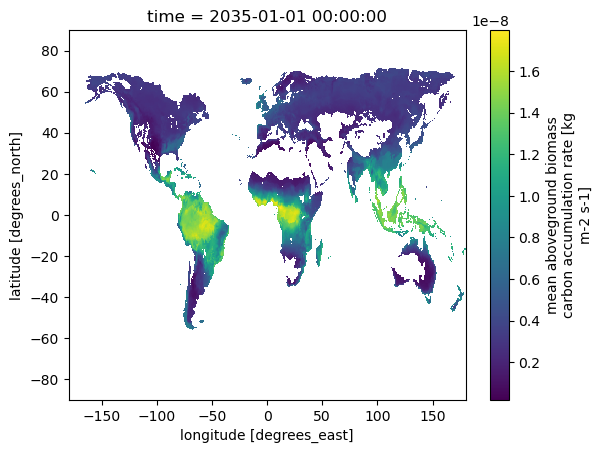

In [28]:
test_t0 = test.isel(time=0)
test['fVeg'].plot()

In [29]:
# try to switch order of dimensions: time, nv, lat, lon
test

<xarray.Dataset> Size: 2MB
Dimensions:         (time: 1, lon: 720, lat: 360, nv: 2)
Coordinates:
  * time            (time) object 8B 2035-01-01 00:00:00
  * lon             (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat             (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Dimensions without coordinates: nv
Data variables:
    fVeg            (time, lat, lon) float32 1MB ...
    time_bounds     (time, nv) object 16B ...
    standard_error  (time, lat, lon) float32 1MB ...
Attributes:
    title:        Carbon accumulation potential from natural forest regrowth ...
    institution:  Global Forest Watch
    source:       Ensemble of 100 random forest models using ground measureme...
    history:      \n2024-05-14 13:36:33: downloaded source from https://www.a...
    references:   \n@article{Cook-Patton2020,\nauthor  = {Cook-Patton, Susan ...
    comment:      
    Conventions:  CF-1.11

### compare to another dataset

In [30]:
# determine a standardized way to name .nc files
ds1 = xr.open_dataset('/home/6ru/Desktop/ILAMB-Data/albedo_0.5x0.5.nc', engine='netcdf4')

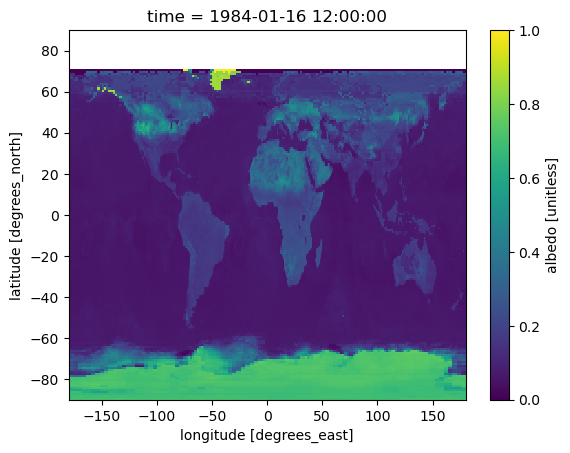

In [31]:
ds1_t0 = ds1.isel(time=0)
ds1_t0['albedo'].plot()

In [32]:
ds1

<xarray.Dataset> Size: 299MB
Dimensions:      (time: 288, nv: 2, lat: 360, lon: 720)
Coordinates:
  * time         (time) object 2kB 1984-01-16 12:00:00 ... 2007-12-16 12:00:00
  * lat          (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon          (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) object 5kB ...
    albedo       (time, lat, lon) float32 299MB ...
Attributes:
    creation_date:        Mon Jun 30 23:00:33 PDT 2014
    Conventions:          Please contact Prof. James Randerson (Email: jrande...
    source_file:          This product is generated from monthly 1 degree GEW...
    title:                derived GEWEX SRB Radiation
    Approach:             To obtain albedo from GEWEX SRB radiation data, I d...
    Temporal resolution:  monthly
    General information:  This product was derived from NASA GEWEX SRB radiat...
    Spatial resolution:   0.5x0.5 degree
    Derived data code:    http://redwood.ess.uci.edu/mingquan/www/ILAMB/Downl...